<a href="https://colab.research.google.com/github/sayid-alt/kulitku-bangkit2024/blob/main/Machine%20Learning/skin_type/skin_type_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libarary

In [1]:
!pip install keras-tuner --upgrade

import zipfile
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import keras_tuner
import keras

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from google.colab import files

import datetime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


# Download data from kaggle

In [2]:
!pip install kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayidheykal","key":"e6e9a20922c6182e48e1cbac69a56342"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shakyadissanayake/oily-dry-and-normal-skin-types-dataset

Dataset URL: https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset
License(s): Apache 2.0
100% 124M/124M [00:08<00:00, 22.5MB/s]
100% 124M/124M [00:08<00:00, 15.5MB/s]


# Utilities

In [4]:
def move_files(source_dir, destination_dir):
    # Ensure the source and destination directories exist
    if not os.path.exists(source_dir):
        print(f"The source directory '{source_dir}' does not exist.")
        return

    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
        print(f"Created the destination directory '{destination_dir}'.")

    # List all files in the source directory
    files = os.listdir(source_dir)

    # Loop through all files and move them to the destination directory
    sum = 0
    for file_name in files:
        # Construct full file path
        source_file = os.path.join(source_dir, file_name)
        destination_file = os.path.join(destination_dir, file_name)

        # Move the file
        shutil.move(source_file, destination_file)
        sum+=1

    print(f'successfully moved {sum} files from {source_dir} to {destination_dir}')



def unzip_file(zip_path, extract_to='.'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def create_directory(path):
    try:
        os.makedirs(path, exist_ok=True)
        print(f"Directory '{path}' created successfully.")
    except Exception as e:
        print(f"Error creating directory '{path}': {e}")



def count_files_and_directories(path):
    file_count = 0
    directory_count = 0

    for dirpath, dirnames, filenames in os.walk(path):
        # Count the number of files in the current directory
        file_count += len(filenames)
        # Count the number of subdirectories in the current directory
        directory_count += len(dirnames)

    return file_count, directory_count


def convert_pb_to_tflite(pb_model_path, tflite_model_path):
    # Load the TensorFlow model
    converter = tf.lite.TFLiteConverter.from_saved_model(pb_model_path)

    # Convert the model to TFLite format
    tflite_model = converter.convert()

    # Save the converted model to a file
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    print(f"Model converted and saved to {tflite_model_path}")


def plot_portion(values, labels, title='Portion of values'):
  fig, ax = plt.subplots()

  sum_values = sum(values)
  percentages = [value / sum_values for value in values]

  bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

  # Create horizontal bar chart
  bars = ax.bar(labels, values, color=bar_colors, label=labels)

  # Add labels to bars with customizations
  ax.bar_label(bars, labels=[f'{round(v * 100, 2)} %' for v in percentages], padding=3, fontsize=10, label_type='center')

  # Set labels
  ax.set_ylabel('values')
  ax.set_title(title)
  ax.legend(title='categories')

  # Show the plot
  plt.show()

def plot_acc_loss(history):
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # save graph to png
  pngfile = 'acc_loss.png'
  if os.path.isfile(pngfile):
    plt.savefig('acc_loss(1).png')
  plt.savefig(f'acc_loss.png')

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  print(f'accuracy\t: {acc[len(acc)-1]}, val_accuracy\t: {val_acc[len(val_acc)-1]}')

  print(f'loss\t\t: {loss[len(loss)-1]}, val_loss\t: {val_loss[len(val_loss)-1]}')


def move_files_after_split(X, y, base_dir):
  sum = 0
  for source_dir, category in zip(X, y):
    filename = source_dir.split('/')[-1]
    destination_dir = os.path.join(base_dir, category, filename)
    shutil.move(source_dir, destination_dir)
    sum+= 1
  print(f'successfully moved {sum} files to {destination_dir}')

def checking_dir_qty(base_dir, train_dir, valid_dir, test_dir):
  num_train, num_train_labels = count_files_and_directories(train_dir)
  num_valid, num_valid_labels = count_files_and_directories(valid_dir)
  num_test, num_test_labels = count_files_and_directories(test_dir)

  all, _ = count_files_and_directories(base_dir)

  print(f'number of images: {all}\n-------------------\n')
  print(f'train data length: {num_train}\nNum of train labels: {num_train_labels}\npercentage: {round(num_train/all*100,2)} %\n')
  print(f'valid data length: {num_valid}\nNum of train labels: {num_valid_labels}\npercentage: {round(num_valid/all*100,2)} %\n')
  print(f'test data length: {num_test}\nNum of test labels: {num_test_labels}\npercentage: {round(num_test/all*100,2)} %\n')

def zip_directory(directory_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, start=directory_path)
                zipf.write(file_path, arcname=arcname)

    print(f'successfull zipping {directory_path} to {zip_path}')





In [5]:
dataset_dir = '/content/oily-dry-and-normal-skin-types-dataset'
if os.path.isdir(dataset_dir):
  shutil.rmtree(dataset_dir)

# Unzip dataset
zip_path = dataset_dir + '.zip'
unzip_file(zip_path)

# Generate data

In [6]:
# defined directories
# -------------------

# base working directory
base_dir = '/content/Oily-Dry-Skin-Types/'

# training data directory
train_dir = base_dir + 'train'

 # validation data directory
valid_dir = base_dir + 'valid'

# test data directory
test_dir = base_dir + 'test'

train_dir, valid_dir, test_dir

('/content/Oily-Dry-Skin-Types/train',
 '/content/Oily-Dry-Skin-Types/valid',
 '/content/Oily-Dry-Skin-Types/test')

## Gathering all picture to one folder as their categories

In [7]:
checking_dir_qty(base_dir, train_dir, valid_dir, test_dir)

number of images: 3153
-------------------

train data length: 2756
Num of train labels: 3
percentage: 87.41 %

valid data length: 262
Num of train labels: 3
percentage: 8.31 %

test data length: 134
Num of test labels: 3
percentage: 4.25 %



In [8]:
# define class names as a label
categories = [name for name in os.listdir(train_dir)]
categories

['oily', 'normal', 'dry']

In [9]:
# create dicertories for all existing data
all_dir = os.path.join(base_dir, 'all')

for cat in categories:
  create_directory(os.path.join(all_dir, cat))

# move all images to the all directory as a default before splitted
for dirname in [train_dir, valid_dir, test_dir]:
  for cat in categories:
    source_dir = os.path.join(dirname, cat)
    destination_dir = os.path.join(all_dir, cat)
    move_files(source_dir, destination_dir)


Directory '/content/Oily-Dry-Skin-Types/all/oily' created successfully.
Directory '/content/Oily-Dry-Skin-Types/all/normal' created successfully.
Directory '/content/Oily-Dry-Skin-Types/all/dry' created successfully.
successfully moved 1000 files from /content/Oily-Dry-Skin-Types/train/oily to /content/Oily-Dry-Skin-Types/all/oily
successfully moved 1104 files from /content/Oily-Dry-Skin-Types/train/normal to /content/Oily-Dry-Skin-Types/all/normal
successfully moved 652 files from /content/Oily-Dry-Skin-Types/train/dry to /content/Oily-Dry-Skin-Types/all/dry
successfully moved 80 files from /content/Oily-Dry-Skin-Types/valid/oily to /content/Oily-Dry-Skin-Types/all/oily
successfully moved 111 files from /content/Oily-Dry-Skin-Types/valid/normal to /content/Oily-Dry-Skin-Types/all/normal
successfully moved 71 files from /content/Oily-Dry-Skin-Types/valid/dry to /content/Oily-Dry-Skin-Types/all/dry
successfully moved 40 files from /content/Oily-Dry-Skin-Types/test/oily to /content/Oily-

# EDA

Checking All data in test, train, valid folder (should be empty)

In [10]:
checking_dir_qty(base_dir, train_dir, valid_dir, test_dir)

number of images: 3153
-------------------

train data length: 0
Num of train labels: 3
percentage: 0.0 %

valid data length: 0
Num of train labels: 3
percentage: 0.0 %

test data length: 0
Num of test labels: 3
percentage: 0.0 %



## Look up the quantities of the category directory

oily : 1120
normal : 1274
dry : 758


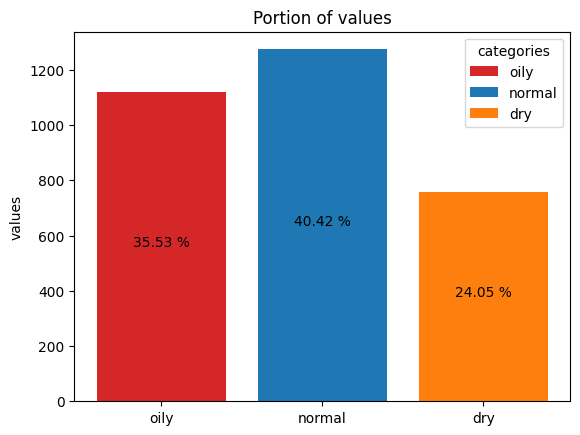

In [11]:
values = []
for i, class_name in enumerate(categories):
  class_length = len(os.listdir(os.path.join(all_dir, class_name)))
  values.append(class_length)
  print(f'{class_name} : {class_length}')

plot_portion(values, categories)

## Data Distribution

(array([1., 0., 2.]),
 array([ 758.,  930., 1102., 1274.]),
 <BarContainer object of 3 artists>)

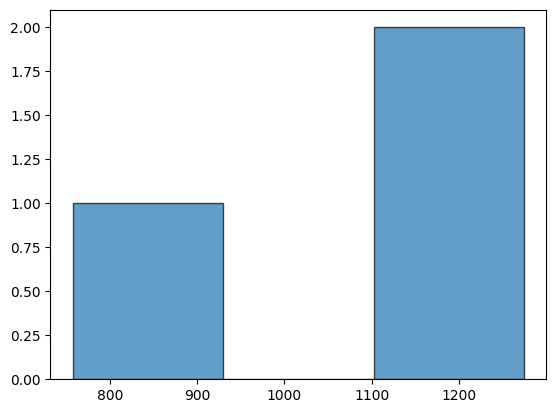

In [12]:
plt.hist(values, bins=3, alpha=0.7, edgecolor='black')

# Data Preprocessing

In [13]:
count_files_and_directories('/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all')

(0, 0)

In [14]:
images, category = [], []
for cat in categories:
  path_cat = os.listdir(os.path.join(all_dir, cat))
  for image in path_cat:
    images.append(os.path.join(all_dir, cat, image))
    category.append('dry' if cat == 'dry' else 'normal' if cat == 'normal' else 'oily')


df = pd.DataFrame({'images':images, 'category':category})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.iloc[77]['images'].split('/')[-1]

'normal_2a654e6820c321c2cd61_jpg.rf.b7b825a9ed6002003a24d7adfd66b3bd.jpg'

## Split data

In [15]:
# Split Train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(df['images'], df['category'],
                                                      test_size=0.2, random_state=42,
                                                      stratify=df['category'])

# Split validation set for test set
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.2,
                                                    random_state=42, stratify=y_valid)

train: 2521
valid: 504
X_test : 127


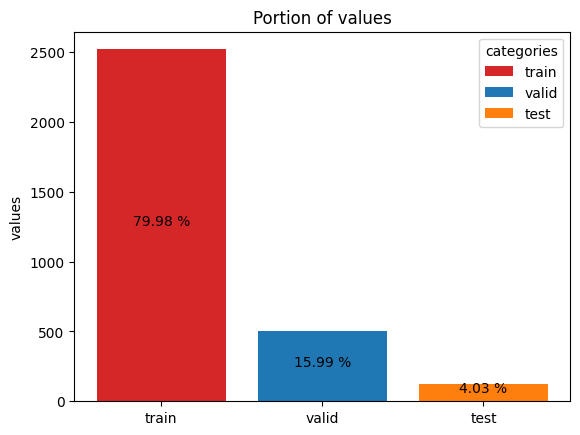

In [16]:
# check qty of split
print(f'train: {len(X_train)}\nvalid: {len(X_valid)}\nX_test : {len(X_test)}')
plot_portion(values=[len(X_train), len(X_valid), len(X_test)], labels=['train', 'valid', 'test'])

In [17]:
# Moving a train files to train directory
move_files_after_split(X_train, y_train, train_dir)
move_files_after_split(X_valid, y_valid, valid_dir)
move_files_after_split(X_test, y_test, test_dir)

successfully moved 2521 files to /content/Oily-Dry-Skin-Types/train/dry/dry_93553a3d9e1ef7ee0f56_jpg.rf.877e3e953cc77b54ee75515f664e74aa.jpg
successfully moved 504 files to /content/Oily-Dry-Skin-Types/valid/oily/oily_a2c8187d92132c9cb25e_jpg.rf.903cc46d7d12907d452f9f0181259c13.jpg
successfully moved 127 files to /content/Oily-Dry-Skin-Types/test/dry/dry_b088908102ba6469f5cc_jpg.rf.0a034f84ade649b35abd61b96862731c.jpg


In [18]:
# Check if the images from (all) category is moved
count_files_and_directories(os.path.join(base_dir, 'all'))

(0, 3)

In [19]:
# Check if the images is moved as a split portion
print(count_files_and_directories(os.path.join(base_dir, 'test'))) # return len of (files, directories)
print(count_files_and_directories(os.path.join(base_dir, 'train')))# return len of (files, directories
print(count_files_and_directories(os.path.join(base_dir, 'valid')))# return len of (files, directories

(127, 3)
(2521, 3)
(504, 3)


# Download splitted dataset

In [20]:
# remove temp file -(all) category-
shutil.rmtree(os.path.join(base_dir, 'all'))

## Zipping splitted dataset file

In [21]:
directory_path = base_dir
zip_path = 'skin-type-dataset.zip'
zip_directory(directory_path, zip_path)
print(f"Directory '{directory_path}' has been zipped as '{zip_path}'")

successfull zipping /content/Oily-Dry-Skin-Types/ to skin-type-dataset.zip
Directory '/content/Oily-Dry-Skin-Types/' has been zipped as 'skin-type-dataset.zip'


# Generate Data (after split 80/15/5)

In [22]:
# Unzip dataset
zip_path = '/content/skin-type-dataset.zip'
dataset_path = '/content/skin_type_dataset'

if os.path.isdir(dataset_path):
  shutil.rmtree(dataset_path)

unzip_file(zip_path, extract_to=dataset_path)

In [23]:
# defined directories
# -------------------

# base working directory
base_dir = dataset_path

# remove readme file
readme_file = os.path.join(base_dir, 'README.dataset.txt')
if os.path.isfile(readme_file):
  os.remove(readme_file)

# training data directory
train_dir = os.path.join(base_dir, 'train')

 # validation data directory
valid_dir =os.path.join(base_dir, 'valid')

# test data directory
test_dir = os.path.join(base_dir, 'test')

train_dir, valid_dir, test_dir

('/content/skin_type_dataset/train',
 '/content/skin_type_dataset/valid',
 '/content/skin_type_dataset/test')

## Data generator

In [24]:
# create imageDataGenerator instance
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
# create Generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

validation_generator = validation_datagen.flow_from_directory(valid_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

Found 2521 images belonging to 3 classes.
Found 504 images belonging to 3 classes.
Found 127 images belonging to 3 classes.


In [26]:
train_generator.class_indices

{'dry': 0, 'normal': 1, 'oily': 2}

# Data Visualitaion

In [27]:
split_names = ['train','valid', 'test']
num_train, _ = count_files_and_directories(train_dir)
num_valid, _ = count_files_and_directories(valid_dir)
num_test, _ = count_files_and_directories(test_dir)
values = [num_train, num_valid, num_test]

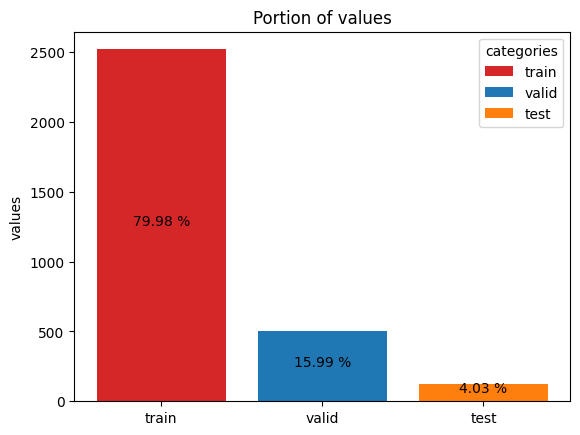

In [28]:
plot_portion(values, split_names)

# Build model

In [29]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94668760/94668760 [==============================] - 5s 0us/step


In [30]:
def build_model(hp):
  x = base_model.output

  if hp.Boolean("flatten"):
      x = Flatten()(x)
  elif hp.Boolean("global_average_pooling"):
      x = GlobalAveragePooling2D()(x)

  # Tune whether to use dropout.
  if hp.Boolean("dropout"):
      x = Dropout(rate=0.25)(x)

  x = Dense(
        # Tune number of units.
        units=hp.Int("units", min_value=32, max_value=1024, step=32),
        activation='relu')(x)

  # Tune whether to use dropout.
  if hp.Boolean("dropout"):
      x = Dropout(rate=0.25)(x)

  x = Dense(
        # Tune number of units.
        units=hp.Int("units", min_value=32, max_value=512, step=32),
        activation='relu')(x)

  if hp.Boolean("batch_normalization"):
    x = BatchNormalization()(x)

  predictions = Dense(3, activation='softmax')(x)

  # Create model
  model = Model(inputs=base_model.input, outputs=predictions)

  # Define the optimizer learning rate as a hyperparameter.
  learning_rate = hp.Float("learning_rate", min_value=1e-6, max_value=1e-2, sampling="log")

  # Define learning rate scheduler
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(optimizer=Adam(learning_rate=lr_schedule),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

# create a model
model = build_model(keras_tuner.HyperParameters())
model

## Hyperparameter tuning

In [31]:
# define tuner using RandomSearch
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    overwrite=False,
    directory="/content/keras_tuner/",
    project_name="skin_type_model",
)

# print search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 6
flatten (Boolean)
{'default': False, 'conditions': []}
global_average_pooling (Boolean)
{'default': False, 'conditions': []}
dropout (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
batch_normalization (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [32]:
# start search best parameters
tuner.search(train_generator, epochs=2, validation_data=validation_generator)

Trial 5 Complete [00h 03m 06s]
val_accuracy: 0.377976194024086

Best val_accuracy So Far: 0.4305555522441864
Total elapsed time: 00h 15m 42s


## Query Result

In [33]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

In [34]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [35]:
best_model.save('best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
tuner.results_summary()

Results summary
Results in /content/keras_tuner/skin_type_model
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
flatten: True
global_average_pooling: True
dropout: True
units: 256
batch_normalization: True
learning_rate: 4.098863679660244e-05
Score: 0.4305555522441864

Trial 3 summary
Hyperparameters:
flatten: True
global_average_pooling: True
dropout: True
units: 832
batch_normalization: False
learning_rate: 0.0009218765360514928
Score: 0.4007936418056488

Trial 2 summary
Hyperparameters:
flatten: False
global_average_pooling: True
dropout: False
units: 960
batch_normalization: True
learning_rate: 0.00029015957004304473
Score: 0.3869047611951828

Trial 4 summary
Hyperparameters:
flatten: True
global_average_pooling: True
dropout: True
units: 64
batch_normalization: True
learning_rate: 9.731591867533164e-06
Score: 0.377976194024086

Trial 0 summary
Hyperparameters:
flatten: False
global_average_pooling: True
dropout: False
units:

In [ ]:
!zip -r /content/skin_type_model.zip /content/keras_tuner/skin_type_model

In [ ]:
# files.download('/content/skin_type_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Set Callbacks

In [37]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/ckpt/model_{epoch:02d}_{accuracy:.2f}_{val_accuracy:.2f}_v02.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

backup_restore = keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")

csv_logger = tf.keras.callbacks.CSVLogger(f'/content/csv_logger.csv')

## Retrain Models

In [38]:
def train_model(epochs, steps_per_epoch, tuner, unfreeze=None, callbacks=None):
  # Get the top 2 hyperparameters.
  best_hps = tuner.get_best_hyperparameters(5)

  # Build the model with the best hp.
  model = build_model(best_hps[0])

  # # freeze some layers and
  # for layer in base_model.layers:
  #   layer.trainable = False

  # if unfreeze is not None:
  #   # unfreeze some layers
  #   for layer in base_model.layers[-unfreeze:]:
  #     layer.trainable = True

  history = model.fit(train_generator, epochs=epochs,
            batch_size=32,
            verbose=2,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // validation_generator.batch_size,
            callbacks=[callbacks])

  return history

In [41]:
EPOCHS = 50
steps_per_epoch = train_generator.samples // train_generator.batch_size
callbacks = [ckpt_callback, csv_logger]

In [42]:

history = train_model(epochs=EPOCHS,
                      steps_per_epoch=steps_per_epoch, tuner=tuner,
                      callbacks=callbacks)

Epoch 1/50
78/78 - 56s - loss: 1.2232 - accuracy: 0.3495 - val_loss: 1.0933 - val_accuracy: 0.3479 - 56s/epoch - 717ms/step
Epoch 2/50
78/78 - 32s - loss: 1.1649 - accuracy: 0.3592 - val_loss: 1.0982 - val_accuracy: 0.4042 - 32s/epoch - 404ms/step
Epoch 3/50
78/78 - 32s - loss: 1.1773 - accuracy: 0.3909 - val_loss: 1.0873 - val_accuracy: 0.4062 - 32s/epoch - 414ms/step
Epoch 4/50
78/78 - 32s - loss: 1.1470 - accuracy: 0.4014 - val_loss: 1.1711 - val_accuracy: 0.3958 - 32s/epoch - 410ms/step
Epoch 5/50
78/78 - 31s - loss: 1.1880 - accuracy: 0.4034 - val_loss: 1.0949 - val_accuracy: 0.4042 - 31s/epoch - 401ms/step
Epoch 6/50
78/78 - 32s - loss: 1.1284 - accuracy: 0.4086 - val_loss: 1.1864 - val_accuracy: 0.4042 - 32s/epoch - 411ms/step
Epoch 7/50
78/78 - 32s - loss: 1.1319 - accuracy: 0.4194 - val_loss: 1.0822 - val_accuracy: 0.4000 - 32s/epoch - 409ms/step
Epoch 8/50
78/78 - 32s - loss: 1.1475 - accuracy: 0.4194 - val_loss: 1.0828 - val_accuracy: 0.3979 - 32s/epoch - 408ms/step
Epoch 9/

KeyboardInterrupt: 

# Evaluation

## Download best model after retrained

In [ ]:
model_retrained_dir = '/content/ckpt/model_48_0.94_0.86_v02'
model_retrained_zip_path = 'content/best_model_retrained.zip'
zip_directory(directory_path=model_retrained_dir, zip_path=model_retrained_zip_path)

In [ ]:
files.download('best_model_retrained.zip')

In [ ]:
!saved_model_cli show --dir /content/ckpt/model_48_0.94_0.86_v02 --all

2024-06-21 09:30:40.463279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_5'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
The Me

In [ ]:
# Load saved Model from checkpoint
model_retrained_dir = '/content/ckpt/model_48_0.94_0.86_v02'
model_retrained = tf.saved_model.load(model_retrained_dir, tags=['serve'])

In [ ]:
# Define a function to wrap the loaded model for evaluation
class LoadedModelWrapper(tf.keras.Model):
    def __init__(self, loaded_model):
        super(LoadedModelWrapper, self).__init__()
        self.loaded_model = loaded_model
        self.infer = loaded_model.signatures['serving_default']

    def call(self, inputs):
        return self.infer(tf.convert_to_tensor(inputs))['dense_5']

# Create an instance of the wrapper model
wrapped_model = LoadedModelWrapper(model_retrained)

# Compile the wrapped model (necessary to use the evaluate method)
wrapped_model.compile(optimizer=Adam(learning_rate=1.7760858545803447e-05), loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the wrapped model using the test data generator
val_loss, val_accuracy = wrapped_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


AttributeError: 'TFSMLayer' object has no attribute 'evaluate'

In [ ]:
# Plot training & validation accuracy values
plot_acc_loss(history)

NameError: name 'history' is not defined

## Visualize the correctly predicted

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


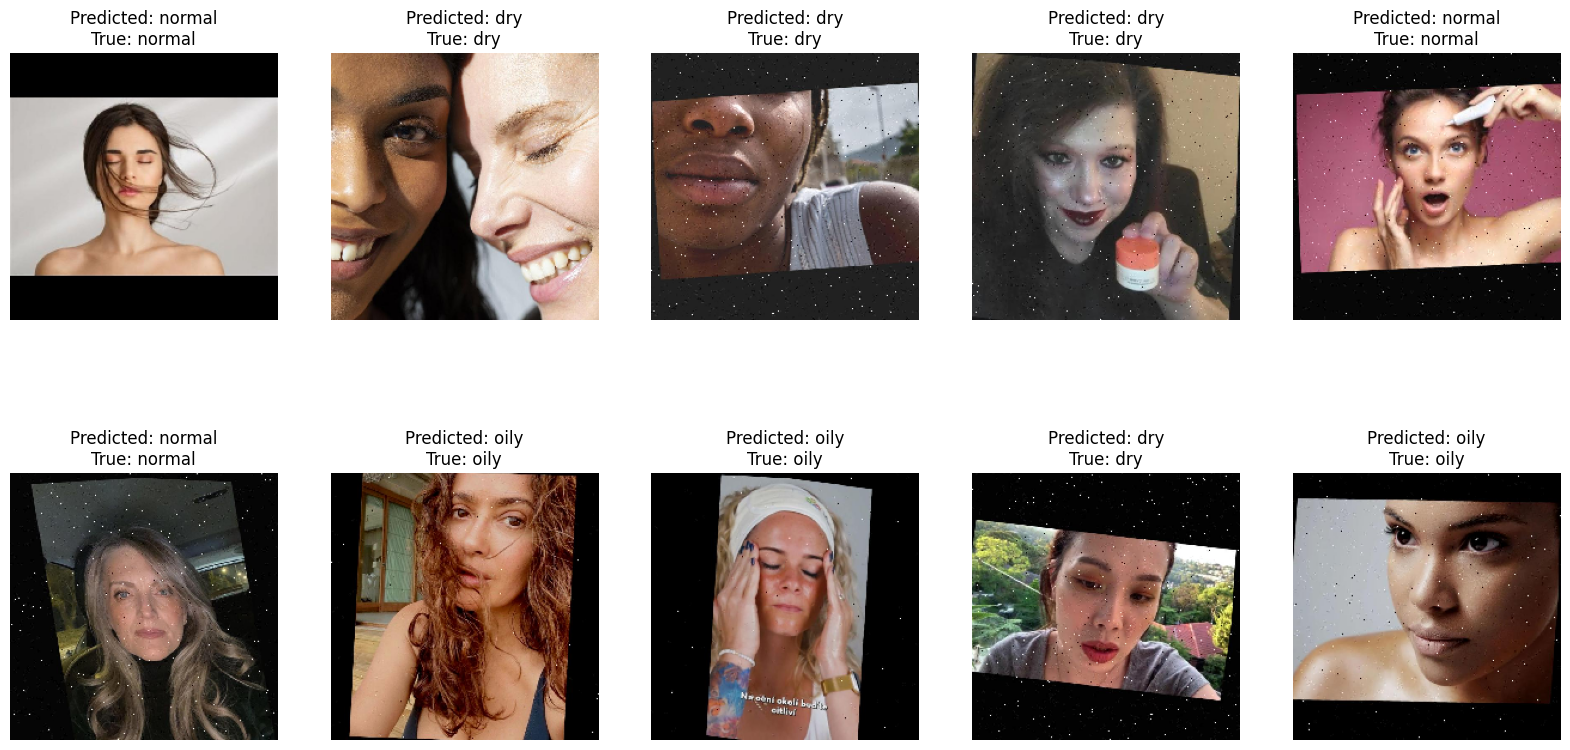

In [ ]:
# Get the class indices
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

# Get a batch of images and labels
images, labels = next(test_generator)

# Predict using the model
predictions = wrapped_model.predict(images)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Find correctly predicted images
correct_indices = np.where(predicted_classes == true_classes)[0]

# Plot the first 10 correctly predicted images
plt.figure(figsize=(20, 10))
for i, idx in enumerate(correct_indices[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx])
    plt.title(f"Predicted: {class_labels[predicted_classes[idx]]}\nTrue: {class_labels[true_classes[idx]]}")
    plt.axis('off')

plt.show()

# Deployment

## Freeze a TensorFlow Model

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

infer = model_retrained.signatures['serving_default']

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: infer(x))
concrete_func = full_model.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Convert variables to constants (freeze the model)
frozen_func = convert_variables_to_constants_v2(concrete_func)
frozen_func.graph.as_graph_def()


# Save frozen graph to disk
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=model_retrained_dir,
                  name="frozen_graph.pb",
                  as_text=False)

'/content/ckpt/model_48_0.94_0.86_v02/frozen_graph.pb'

## Convert saved model pb to tflite

In [ ]:
pb_model_path = model_retrained_dir
tflite_model_path = 'model.tflite'
convert_pb_to_tflite(pb_model_path, tflite_model_path)

Model converted and saved to model.tflite


## Convert savedModel to tfjs

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    /content/ckpt/model_48_0.94_0.86_v02\
    /content/web_model_test

2024-06-21 10:31:10.407167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-21 10:31:12.804069: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 963, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 949, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs

In [ ]:
# zipping tfjs converted directory

zip_directory(directory_path='/content/skin_type_model_64_68_resnet50v2_tfjs', zip_path='/content/skin_type_model_64_68_resnet50v2_tfjs.zip')

successfull zipping /content/skin_type_model_64_68_resnet50v2_tfjs to /content/skin_type_model_64_68_resnet50v2_tfjs.zip
